# Support.py in Notebook

In [11]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


# Code 

In [49]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
import copy

In [13]:
data = load_dataset("dataset_a1.txt")

## Q1

In [20]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox()

NGEN = 30        # Number of Generations
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) # Uses fitness function from support to evaluate fitness
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", tools.mutFlipBit, indpb=INDPB) # indpb is the probability of flipping each bit in the individual
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)  # tournsize is the number of individuals to select for the tournament, fittest is selected for next gen

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

c:\Users\20193217\AppData\Local\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\20193217\AppData\Local\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	max     	avg     	min	std   
0  	100   	-2.69041	-9.70659	-17	3.1647
1  	72    	-1.70291	-6.94568	-13	2.53303
2  	66    	-1.63329	-4.97264	-10	1.8585 
3  	50    	-0.702911	-3.72766	-10	1.48199
4  	53    	-0.482904	-2.81497	-10	1.33668
5  	46    	-0.482904	-2.24837	-8 	1.30162
6  	55    	0.327051 	-1.41937	-5.63329	0.981954
7  	60    	0.395237 	-0.974182	-6      	0.951531
8  	65    	0.513094 	-0.695385	-4      	0.734107
9  	49    	0.517096 	-0.444213	-6.62976	0.92694 
10 	69    	0.538094 	-0.0469187	-2.50357	0.587471
11 	51    	0.538094 	0.0887681 	-3.78383	0.862914
12 	68    	0.558763 	0.189458  	-3.67988	0.834539
13 	52    	0.558763 	0.190252  	-3.52024	0.922253
14 	56    	0.558763 	0.203833  	-3.75139	0.944061
15 	77    	0.558763 	0.101342  	-3.46191	0.882228
16 	56    	0.558763 	0.276986  	-3.42057	0.804067
17 	61    	0.558763 	0.106758  	-7.73472	1.26639 
18 	54    	0.558763 	0.368126  	-1.52986	0.558371
19 	63    	0.558763 	0.480789  	-3.46191	0.455604
20 	68    	0.5587

In [21]:
best_ind = hof[0]
print("\nBest Individual:")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind)
# print("\nBest Matrix:")
# print(best_matrix)


Best Individual:
[1, 5, 6, 5, 0, 6, 5, 8, 6, 8, 4, 8, 0, 6, 0, 5, 0, 5, 1, 6, 5, 6, 5, 8]
Fitness: 0.5587626262626258


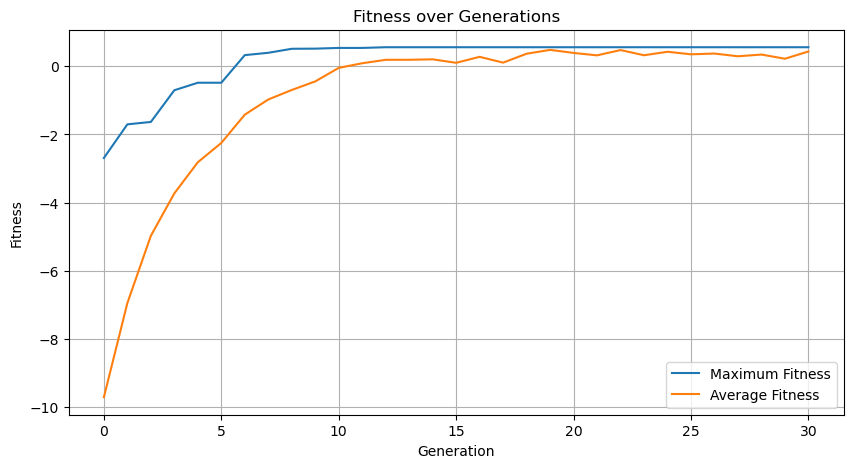

In [22]:
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
len(max_fitness)

31

In [17]:
# Visualize the best Petri net found
output_filename = "best_petri_net.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")


Best Petri net saved to best_petri_net.pdf


In [ ]:
del creator.FitnessMax
del creator.Individual

# Q2

In [53]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Creates a fitness class for maximization
creator.create("Individual", list, fitness=creator.FitnessMax) # Creates an individual class that inherits from list and has a fitness attribute

toolbox = base.Toolbox() # Create new empty toolbox

NGEN = 3        # Number of Generations
NUM_RUNS = 3    # Number of runs for boxplots  
# Just took standard values for hyperparameters
POP_SIZE = 100   # Population size
CXPB = 0.5       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
TOURNSIZE = 3    # Tournament size for selection
INDPB = 0.05     # Independent probability for attributes mutation

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1) # Use NR_PLACES - 1 since indexing starts at 0
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)

crossover_list = [tools.cxTwoPoint, tools.cxOrdered]
mutation_list = [tools.mutFlipBit, tools.mutShuffleIndexes]
selection_list = [tools.selTournament, tools.selRoulette]

combinations = list(itertools.product(crossover_list, mutation_list, selection_list))

In [54]:
def register_specified_variant(toolbox, Crossover, Mutation, Selection):
    toolbox.register("mate", Crossover) 
    toolbox.register("mutate", Mutation, indpb=INDPB) 
    if Selection == tools.selTournament:
        toolbox.register("select", Selection, tournsize=TOURNSIZE) # Try selTournament args, then selRoulette args
    else:
        toolbox.register("select", Selection)
    return toolbox

def run_genetic_algorithm_q2(toolbox, num_runs=NUM_RUNS):
    max_fitnesses_all_runs = []

    for run in range(num_runs):

        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)

        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                           stats=stats, halloffame=hof, verbose=False)
        
        max_fitness = logbook.select("max")
        max_fitnesses_all_runs.append(max_fitness)

    max_fitnesses_all_runs = np.array(max_fitnesses_all_runs).T

    return max_fitnesses_all_runs

def plot_boxplot(max_fitnesses_all_runs, title):
    plt.figure(figsize=(10, 5))
    plt.boxplot(max_fitnesses_all_runs, labels=[f"Run {i+1}" for i in range(NUM_RUNS)])
    plt.xlabel("Runs")
    plt.ylabel("Maximum Fitness")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_ABF(max_fitnesses_all_runs, title):
    plt.figure(figsize=(10, 5))
    plt.plot(max_fitnesses_all_runs, label="Maximum Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
results = {}
i = 0
for i, comb in enumerate(combinations):
    print("Running combination:", i+1, "of", len(combinations))
    tbx = base.Toolbox()
    tbx.__dict__.update(copy.deepcopy(toolbox.__dict__))

    tbx = register_specified_variant(tbx, comb[0], comb[1], comb[2])

    max_fitnesses_all_runs = run_genetic_algorithm_q2(tbx)
    results[i] = max_fitnesses_all_runs

    # i += 1

Running combination: 1 of 8
Running combination: 2 of 8
Running combination: 3 of 8
Running combination: 4 of 8
Running combination: 5 of 8
Running combination: 6 of 8
Running combination: 7 of 8
Running combination: 8 of 8


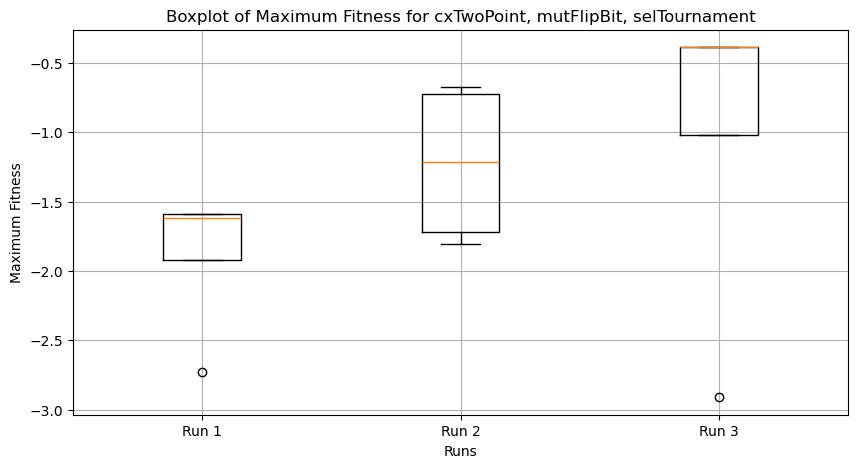

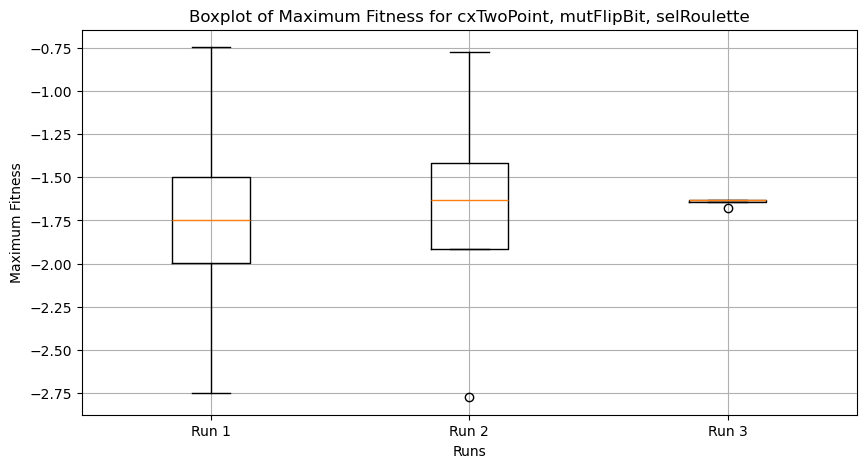

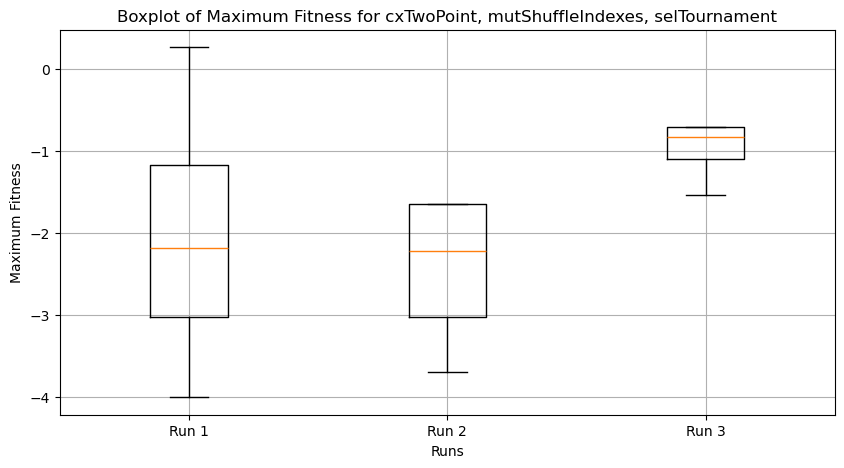

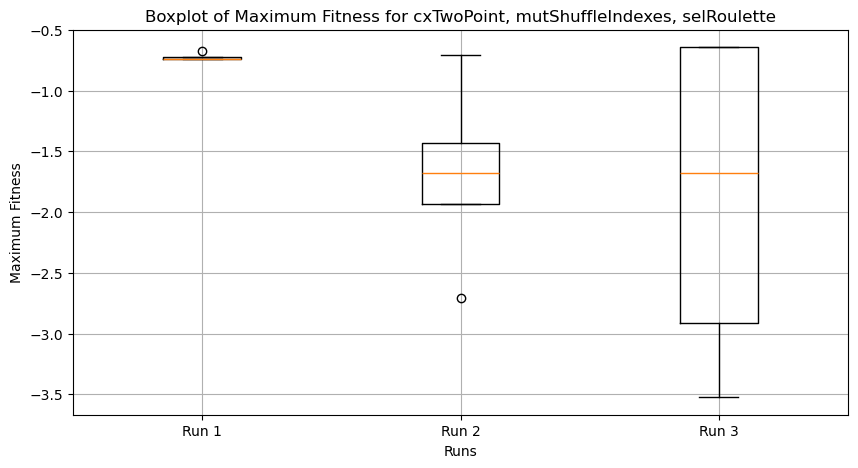

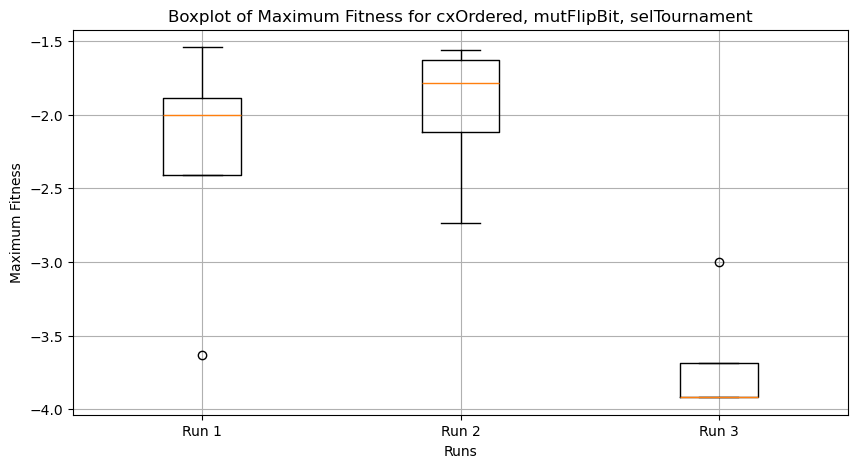

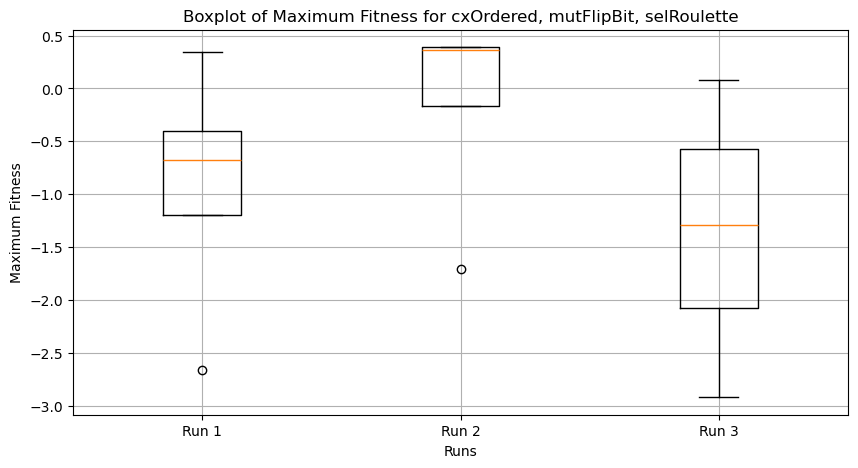

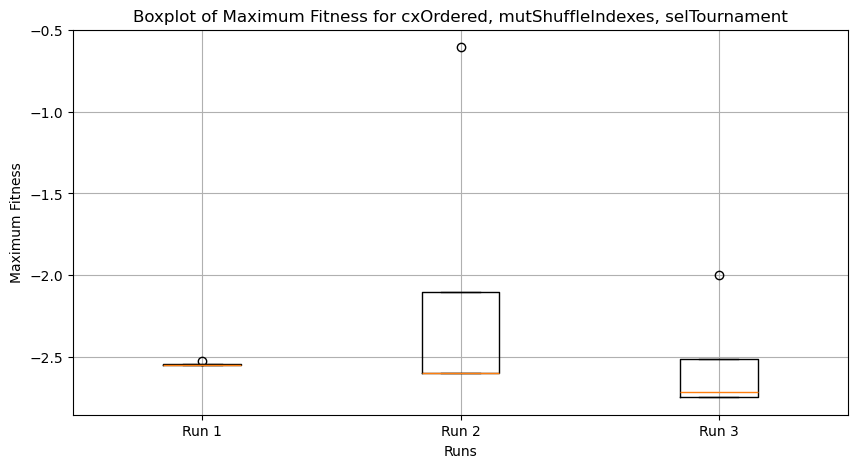

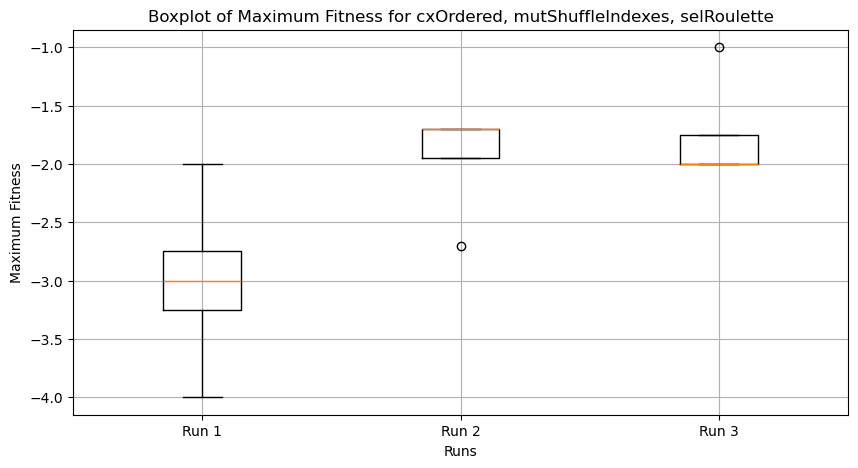

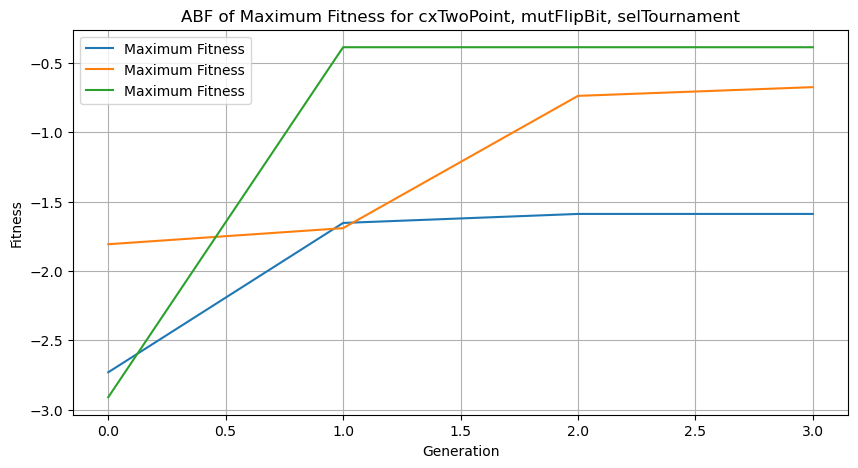

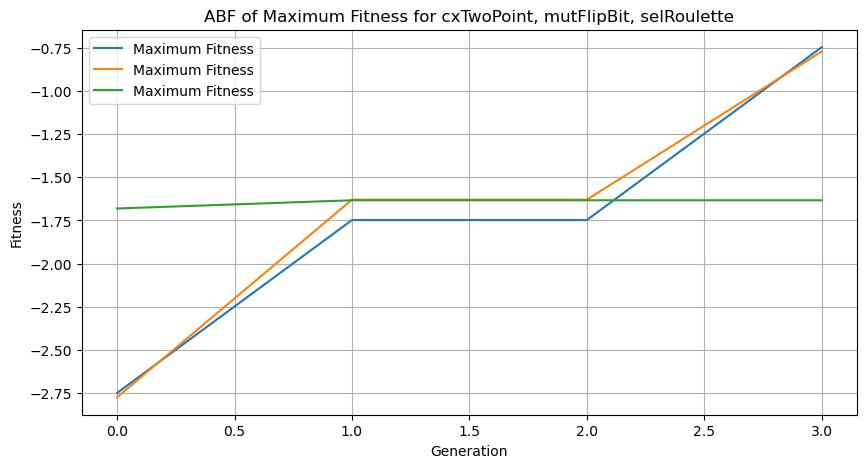

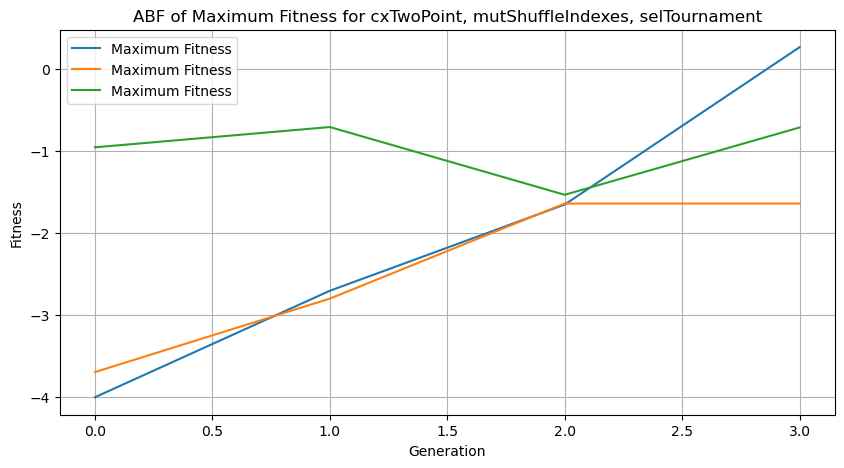

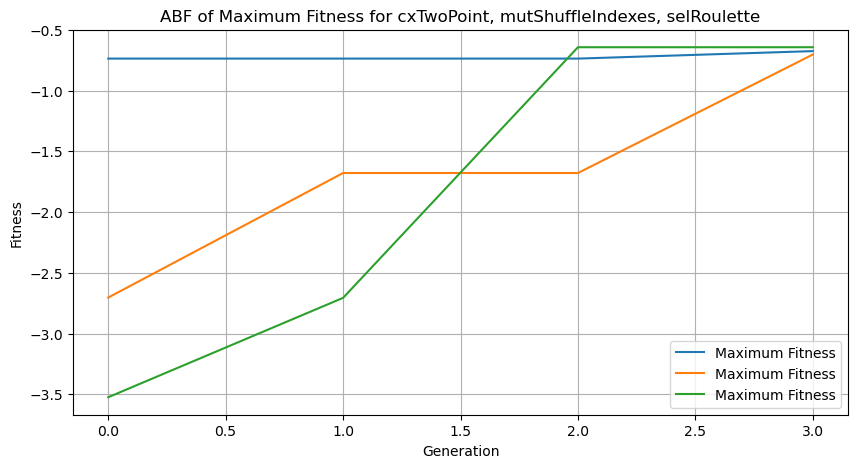

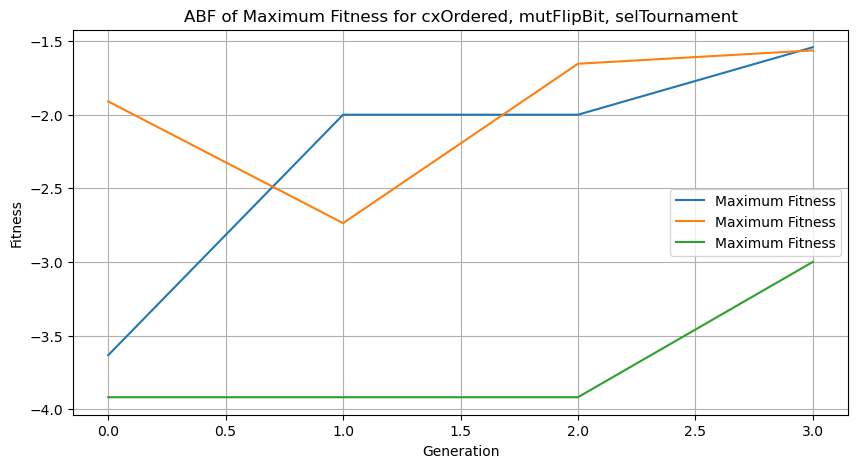

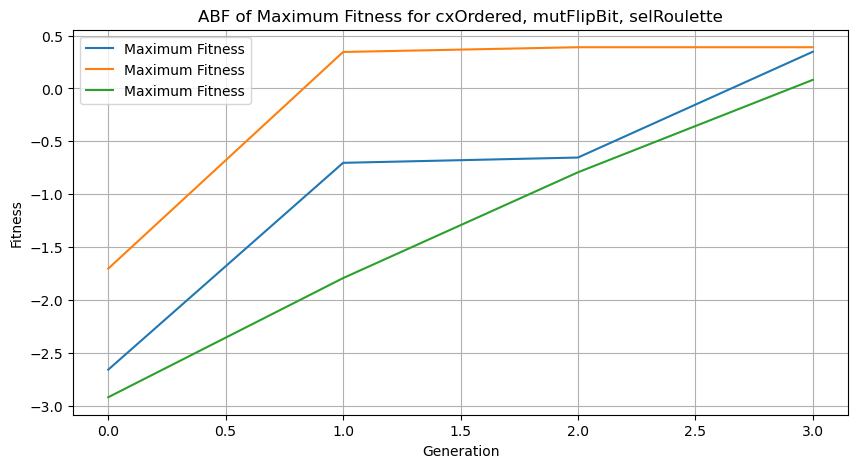

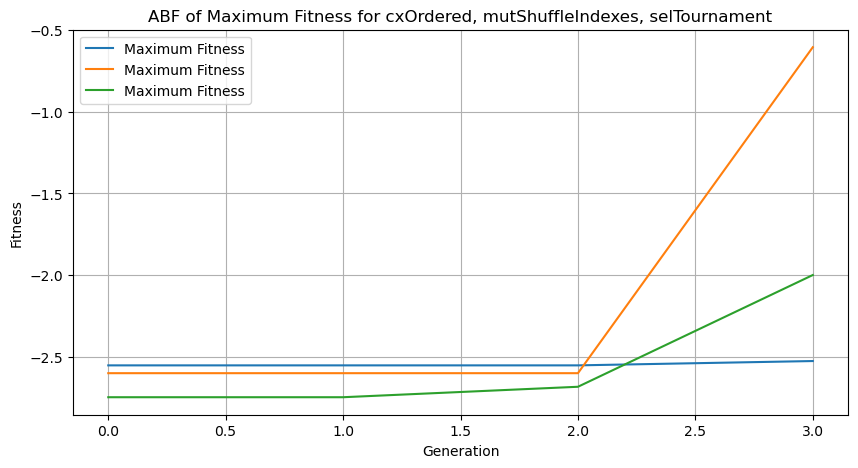

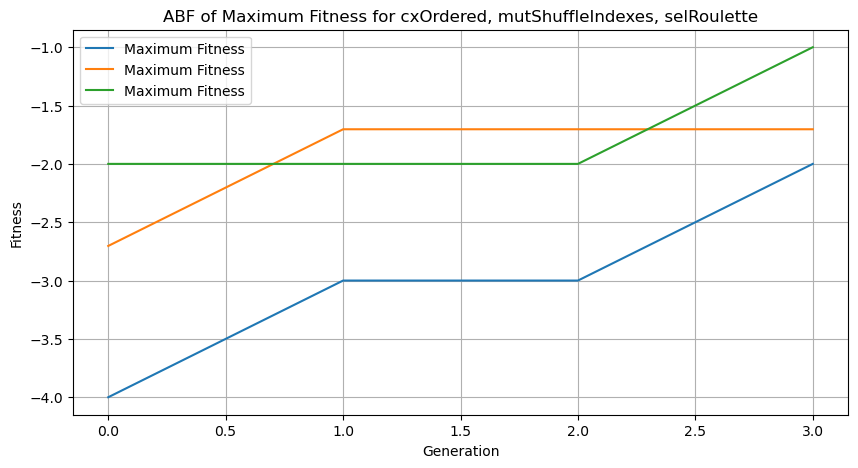

In [56]:
# Plot boxplots for each combination of crossover, mutation, and selection
for i, comb in enumerate(combinations):
    title = f"Boxplot of Maximum Fitness for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
    plot_boxplot(results[i], title)

# Plot ABF for each combination of crossover, mutation, and selection
for i, comb in enumerate(combinations):
    title = f"ABF of Maximum Fitness for {comb[0].__name__}, {comb[1].__name__}, {comb[2].__name__}"
    plot_ABF(results[i], title)

# Q3